# Tutorial: Sensitivity Analysis (SA) using the Saltelli sampling scheme with Sobol SA

In this tutorial, we will set up a workflow to investigate how sensitive the output of a function is to its inputs. Why might you want to do this? Imagine that this function represents a complex system, such as the rainfall-runoff process of a watershed model, and that you, the researcher, want to investigate how your choice of input parameter values are affecting the model's characterization of runoff in the watershed. Your parameter values are likely uncertain and can take on any value in a pre-defined range. Using a Sobol SA will allow you to sample different values of your parameters and calculate how sensitive your output of interest is to certain parameters. Below, we demonstrate Sobol SA for a simple function to illustrate the method, but the workflow can be applied to your own problem of interest!  

In order to conduct this analysis, we will use the popular Python Sensitivity Analysis Library ([SALib](https://salib.readthedocs.io/en/latest/index.html)) to:
1. Generate a problem set as a dictionary for our Ishigami function that has three inputs
2. Generate 2048 samples for our problem set using the Saltelli<sup>[1,2](#references)</sup>. sampling scheme
3. Execute the Ishigami function for each of our samples and gather the outputs
4. Compute the sensitivity analysis to generate first-order and total-order sensitivity indices using the Sobol<sup>3</sup> method
5. Interpret the meaning of our results

## Let's get started!
__NOTE__:  Content from this tutorial is taken directly from the SALib ["Basics"](https://salib.readthedocs.io/en/latest/basics.html) walkthrough. To step through the notebook, execute each gray (code) box by typing "Shift+Enter".

In [1]:
import matplotlib.pyplot as plt 

from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

## Step 1:  Generate the problem dictionary
The Ishigami function is of the form: $$f(x_1,x_2,x_3) = sin(x_1)+asin^2(x_2)+bx_3^4sin(x_1)$$ 

The function has three inputs, 𝑥<sub>1</sub>, 𝑥<sub>2</sub>, 𝑥<sub>3</sub> where 𝑥<sub>𝑖</sub> ∈ [−𝜋, 𝜋]. The constants $a$ and $b$ are defined as 7.0 and 0.1 respectively.

In [2]:
#Create a problem dictionary. Here we supply the number of variables, the names of each variable, and the bounds of the variables.
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}

## Step 2:  Generate samples using the Saltelli sampling scheme
Sobol SA requires the use of the Saltelli sampling scheme.  The output of the `saltelli.sample` function is a NumPy array that is of shape 2048 by 3. The sampler generates 𝑁∗(2𝐷+2) samples, where in this example, N is 256 (the argument we supplied) and D is 3 (the number of model inputs), yielding 2048 samples. The keyword argument `calc_second_order=False` will exclude second-order indices, resulting in a smaller sample matrix with 𝑁∗(𝐷+2) rows instead. Below, we plot the resulting Saltelli sample. 

In [3]:
#Generate parmeter values using the saltelli.sample function
param_values = saltelli.sample(problem, 256)

print(f"`param_values` shape:  {param_values.shape}")


`param_values` shape:  (2048, 3)


/var/folders/81/h441ylh90yn8p6cmrrlp17w00000gn/T/ipykernel_36370/3348538535.py:2: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 256)


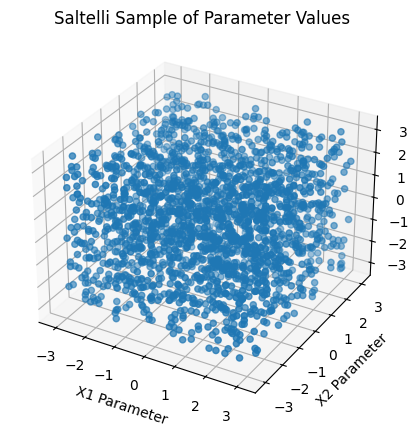

In [4]:
#Plot the 2048 samples of the parameters 

fig = plt.figure(figsize = (7, 5))
ax = plt.axes(projection ="3d")
ax.scatter3D(param_values[:,0], param_values[:,1], param_values[:,2])
ax.set_xlabel('X1 Parameter')
ax.set_ylabel('X2 Parameter')
ax.set_zlabel('X3 Parameter')
plt.title("Saltelli Sample of Parameter Values")

plt.show()

## Step 3:  Execute the Ishigami function over our sample set
SALib provides a nice wrapper to the Ishigami function that allows the user to directly pass the `param_values` array we just generated into the function directly.

In [5]:
Y = Ishigami.evaluate(param_values)

## Step 4:  Compute first-, second-, and total-order sensitivity indices using the Sobol method
The `sobol.analyze` function will use our problem dictionary and the result of the Ishigami runs (`Y`) to compute first-, second-, and total-order indicies.

In [6]:
Si = sobol.analyze(problem, Y)

/Users/rexe871/Library/CloudStorage/OneDrive-PNNL/Documents/IM3/repos/msd_uncertainty_ebook/.venv3.9.12/lib/python3.9/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


`Si` is a Python dict with the keys "S1", "S2", "ST", "S1_conf", "S2_conf", and "ST_conf". The `_conf` keys store the corresponding confidence intervals, typically with a confidence level of 95%. Use the keyword argument `print_to_console=True` to print all indices. Or, we can print the individual values from `Si` as shown in the next step.

## Step 5: Interpret our results
We execute the following code and take a look at our first-order indices (`S1`) for each of our three inputs. These indicies can be interpreted as the fraction of variance in the output that is explained by each input individually. 

In [7]:
first_order = Si['S1']

print('First-order:')
print(f"x1: {first_order[0]}, x2: {first_order[1]}, x3: {first_order[2]}")

First-order:
x1: 0.3184242969763114, x2: 0.4303808201623415, x3: 0.022687722804980225



If we were to rank the importance of the inputs in how much they individually explain the variance in the output, we would rank them from greatest to least importance as follows: 𝑥<sub>2</sub>, 𝑥<sub>1</sub> and then 𝑥<sub>3</sub>. Since 𝑥<sub>3</sub> only explains 2% of the output variance, it does not explain output variability meaningfully. Thus, this indicates that there is contribution to the output variance by 𝑥<sub>2</sub> and 𝑥<sub>1</sub> independently, whereas 𝑥<sub>3</sub> does not contribute to the output variance. Determining what inputs are most important or what index value is meaningful is a common question, but one for which there is no general rule or threshold. This question is problem and context-dependent, but procedures have been identified to rank order influential inputs and which can be used to identify the least influential factors. These factors can be fixed to simplify the model.<sup>[4,5,6](#references)</sup>

Next, we evaluate the total-order indices, which measure the contribution to the output variance caused by varying the model input, including both its first-order effects (the input varying alone) and all higher-order interactions across the input parameters. 

In [8]:
total_order = Si['ST']

print('Total-order:')
print(f"x1: {total_order[0]}, x2: {total_order[1]}, x3: {total_order[2]}")

Total-order:
x1: 0.5184119098161342, x2: 0.4102126025002605, x3: 0.22990584314399523


The magnitude of the total order indices are substantially larger than the first-order indices, which reveals that higher-order interactions are occurring, i.e. that the interactions across inputs are also explaining some of the total variance in the output. Note that 𝑥<sub>3</sub> has non-negligible total-order indices, which indicates that it is not a consequential parameter when considered in isolation, but becomes consequential and explains 25% of variance in the output through its interactions with 𝑥<sub>1</sub> and 𝑥<sub>2</sub>. 

Finally, we can investigate these higher order interactions by viewing the second-order indices.  The second-order indicies measure the contribution to the output variance caused by the interaction between any two model inputs. Some computing error can appear in these sensitivity indices, such as negative values. Typically, these computing errors shrink as the number of samples increases. 

In [9]:
second_order = Si['S2']

print("Second-order:")
print(f"x1-x2:  {second_order[0,1]}")
print(f"x1-x3:  {second_order[0,2]}")
print(f"x2-x3:  {second_order[1,2]}")


Second-order:
x1-x2:  -0.04323738972323421
x1-x3:  0.17506452088709862
x2-x3:  -0.03430682392607577


We can see that there are strong interactions between 𝑥<sub>1</sub> and 𝑥<sub>3</sub>. Note that in the Ishigami function, these two variables are multiplied in the last term of the function, which leads to interactive effects. If we were considering first order indices alone, we would erroneously assume that 𝑥<sub>3</sub> explains no variance in the output, but the second-order and total order indices reveal that this is not the case. It's easy to understand where we might see interactive effects in the case of the simple Ishigami function. However, it's important to remember that in more complex systems, there may be many higher-order interactions that are not apparent, but could be extremely consequential in explaining the variance of the output. 

## Tips to Apply Sobol SA to Your Own Problem 
In this tutorial, we demonstrated how to apply an SA analysis to a simple mathematical test function. In order to apply a Sobol SA to your own problem, you will follow the same general workflow that we defined above. You will need to: 

1. Choose sampling bounds for your parameters and set up the problem dictionary as in Step 1 above. 
2. Generate samples using the `saltelli.sample` function. This step is problem-dependent and note that the Sobol method can be computationally intensive depending on the model being analyzed. For example, for a simple rainfall-runoff model such as HYMOD, it has been recommended to run a sample size of at least N = 10,000 (which translates to 60,000 model runs). More complex models will be slower to run and will also require more samples to calculate accurate estimates of Sobol indices. Once you complete this process, pay attention to the confidence bounds on your sensitivity indices to see whether you need to run more samples. 
3. Run the parameter sets through your model. In the example above, the Ishigami function could be evaluated through SALib since it is a built in function. For your application, you will need to run these parameter sets through the problem externally and save the output. The output file should contain one row of output values for each model run.
4. Calculate the Sobol indices. Now, the Y will be a numpy array with your external model output and you will need to include the parameter samples as an additional argument.
5. Finally, we interpet the results. If the confidence intervals of your dominant indices are larger than roughly 10% of the value itself, you may want to consider increasing your sample size as computation permits. You should additionally read the references noted in Step 5 above to understand more about identify important factors. 

<a id='references'></a>
## References 
[1] Saltelli, A. (2002). “Making best use of model evaluations to compute sensitivity indices.” Computer Physics Communications, 145(2):280-297, doi:10.1016/S0010-4655(02)00280-1.

[2] Saltelli, A., P. Annoni, I. Azzini, F. Campolongo, M. Ratto, and S. Tarantola (2010). “Variance based sensitivity analysis of model output. Design and estimator for the total sensitivity index.” Computer Physics Communications, 181(2):259-270, doi:10.1016/j.cpc.2009.09.018.

[3] Sobol, I. M. (2001). “Global sensitivity indices for nonlinear mathematical models and their Monte Carlo estimates.” Mathematics and Computers in Simulation, 55(1-3):271-280, doi:10.1016/S0378-4754(00)00270-6.

[4] T. H. Andres, “Sampling methods and sensitivity analysis for large parameter sets,” Journal of Statistical Computation and Simulation, vol. 57, no. 1–4, pp. 77–110, Apr. 1997, doi: 10.1080/00949659708811804.

[5] Y. Tang, P. Reed, T. Wagener, and K. van Werkhoven, “Comparing sensitivity analysis methods to advance lumped watershed model identification and evaluation,” Hydrology and Earth System Sciences, vol. 11, no. 2, pp. 793–817, Feb. 2007, doi: https://doi.org/10.5194/hess-11-793-2007.

[6] J. Nossent, P. Elsen, and W. Bauwens, “Sobol’ sensitivity analysis of a complex environmental model,” Environmental Modelling & Software, vol. 26, no. 12, pp. 1515–1525, Dec. 2011, doi: 10.1016/j.envsoft.2011.08.010.